In [1]:
try:
    if installed:
        print('Installed')
except:
    !pip install -q gym[atari,accept-rom-license] ale-py
    installed = True

In [2]:
import cv2
import copy
import random
import gc
import gym
import numpy as np
import torch
import ipywidgets as widgets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from gym import spaces
from tqdm import tqdm
from collections import deque
from IPython import display
from IPython.display import clear_output
from matplotlib import animation

cv2.ocl.setUseOpenCL(False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class Replay_Buffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def store(self, state, action, new_state, reward, done):
        state = np.expand_dims(state, 0)
        new_state = np.expand_dims(new_state, 0)
        
        self.buffer.append([state, action, new_state, reward, done])
    
    def replay(self, batch_size):
        state, action, new_state, reward, done = zip(
            *random.sample(self.buffer, batch_size)
        )
        
        return np.concatenate(state), action, np.concatenate(new_state), reward, done
    
    def __len__(self):
        return len(self.buffer)

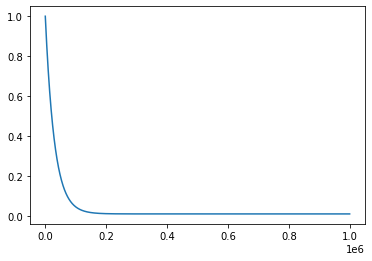

In [4]:
epsilon_S = 1.0
epsilon_E = 0.01
epsilon_decay = 30000

_epsilon = lambda frame: epsilon_E + (epsilon_S - epsilon_E)*np.exp(-frame/epsilon_decay)
plt.plot([_epsilon(frame) for frame in range(1000000)]);

In [5]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.integers(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _, info = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs, info

    def step(self, ac):
        return self.env.step(ac)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _, info = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _, info = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs, info

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condtion for a few frames
            # so its important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, truncated, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs, info = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _, info = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs, info

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def reset(self):
        return self.env.reset()

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, truncated, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, truncated, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """Warp frames to 84x84 as done in the Nature paper and later work."""
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255,
            shape=(self.height, self.width, 1), dtype=np.uint8)

    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[0], shp[1], shp[2] * k), dtype=np.uint8)

    def reset(self):
        ob, info = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob(), info

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=2)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

def make_atari(env_id, render_mode=None):
    env = gym.make(env_id, render_mode = render_mode)
    assert 'NoFrameskip' in env.spec.id
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    return env

def wrap_deepmind(env, episode_life=True, clip_rewards=True, frame_stack=False, scale=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = WarpFrame(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, 4)
    return env



class ImageToPyTorch(gym.ObservationWrapper):
    """
    Image shape to num_channels x weight x height
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], old_shape[0], old_shape[1]), dtype=np.uint8)

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)
    

def wrap_pytorch(env):
    return ImageToPyTorch(env)

In [6]:
env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id, render_mode='rgb_array')
env    = wrap_deepmind(env)
env    = wrap_pytorch(env)

A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]


In [7]:
def compute_td_loss(batch_size, device):
    state, action, reward, next_state, done = replay_buffer.replay(batch_size)

    state      = torch.tensor(state).to(device)
    with torch.no_grad():
        next_state = torch.tensor(next_state).to(device)
    action     = torch.LongTensor(action).to(device)
    reward     = torch.FloatTensor(reward).to(device)
    done       = torch.FloatTensor(done).to(device)

    q_values      = target(state)
    with torch.no_grad():
        next_q_values = behavior(next_state)
    
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - expected_q_value.data).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [8]:
class CnnDDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x = x.float()
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(torch.autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    
    def act(self, state, epsilon):
        with torch.no_grad():
            if random.random() > epsilon:
                state   = torch.FloatTensor(state).unsqueeze(0)
                state = state.to(device)
                q_value = self.forward(state)
                action  = q_value.max(1)[1].item()
            else:
                action = random.randrange(env.action_space.n)
        return action

In [9]:
target = CnnDDQN(env.observation_space.shape, env.action_space.n)
behavior = CnnDDQN(env.observation_space.shape, env.action_space.n)

target = target.to(device)
behavior = behavior.to(device)

optimizer = optim.Adam(target.parameters(), lr=0.00001)

replay_initial = 10000
replay_buffer = Replay_Buffer(100000)

In [10]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(122)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

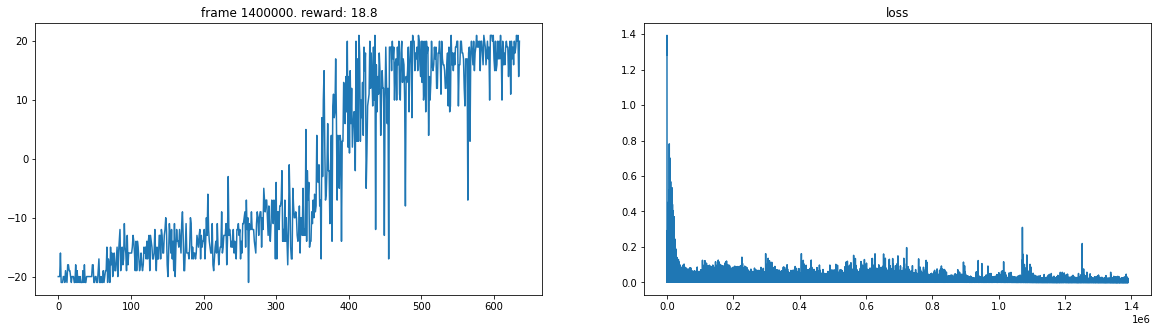

100%|██████████| 1400000/1400000 [8:51:35<00:00, 43.89it/s]


In [11]:
num_frames = 1400000
batch_size = 32
gamma      = 0.99

losses = []
all_rewards = []
episode_reward = 0
step = 0
ep = 0
max_steps = 0

state, _ = env.reset()
for frame_idx in tqdm(range(1, num_frames + 1)):
    
    epsilon = _epsilon(frame_idx)
    action = target.act(state, epsilon)
    
    next_state, reward, done, _, _ = env.step(action)
    replay_buffer.store(state, action, reward, next_state, float(done))
    
    state = next_state
    episode_reward += reward
    step += 1
    
    if frame_idx % 100 == 0:
        # update behavior policy to target
        behavior.load_state_dict(target.state_dict())
        
    if done:
        state, _ = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        max_steps = max(step, max_steps)
        step = 0
        ep += 1
        gc.collect()
        
    if len(replay_buffer) > replay_initial:
        loss = compute_td_loss(batch_size, device)
        losses.append(loss)
      
    if frame_idx % 10000 == 0:
        plot(frame_idx, all_rewards, losses)

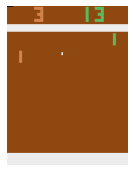

In [12]:
def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=10)

    anim.save(path + filename, writer='imagemagick', fps=6)
    


state, _ = env.reset()
frames = []
for t in tqdm(range(1000)):
    #Render to frames buffer
    frames.append(env.render())
    action = target.act(state, epsilon)
    state, _, done, _, _ = env.step(action)
    if done:
        break

save_frames_as_gif(frames)
clear_output(wait=True)


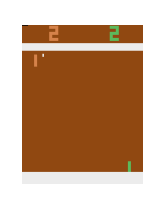

In [13]:
gif_file = './gym_animation.gif'
import base64
from IPython.core.display import display, HTML
b64 = base64.b64encode(open(gif_file,'rb').read()).decode('ascii')
display(HTML(f'<img src="data:image/gif;base64,{b64}" />'))

In [14]:
torch.save(target, 'pingpong_ddqn.pth')